In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
import numpy as np

# 1. Импорт и описание данных

In [43]:
df_genome_scores = pd.read_csv('/kaggle/input/movielens-20m-dataset/genome_scores.csv')
df_genome_tags = pd.read_csv('/kaggle/input/movielens-20m-dataset/genome_tags.csv')
df_link = pd.read_csv('kaggle/input/movielens-20m-dataset/link.csv')
df_movie = pd.read_csv('/kaggle/input/movielens-20m-dataset/movie.csv')
df_rating = pd.read_csv('/kaggle/input/movielens-20m-dataset/rating.csv')
df_tag = pd.read_csv('/kaggle/input/movielens-20m-dataset/tag.csv')

### Схема для обединения наших таблиц в единную БД:
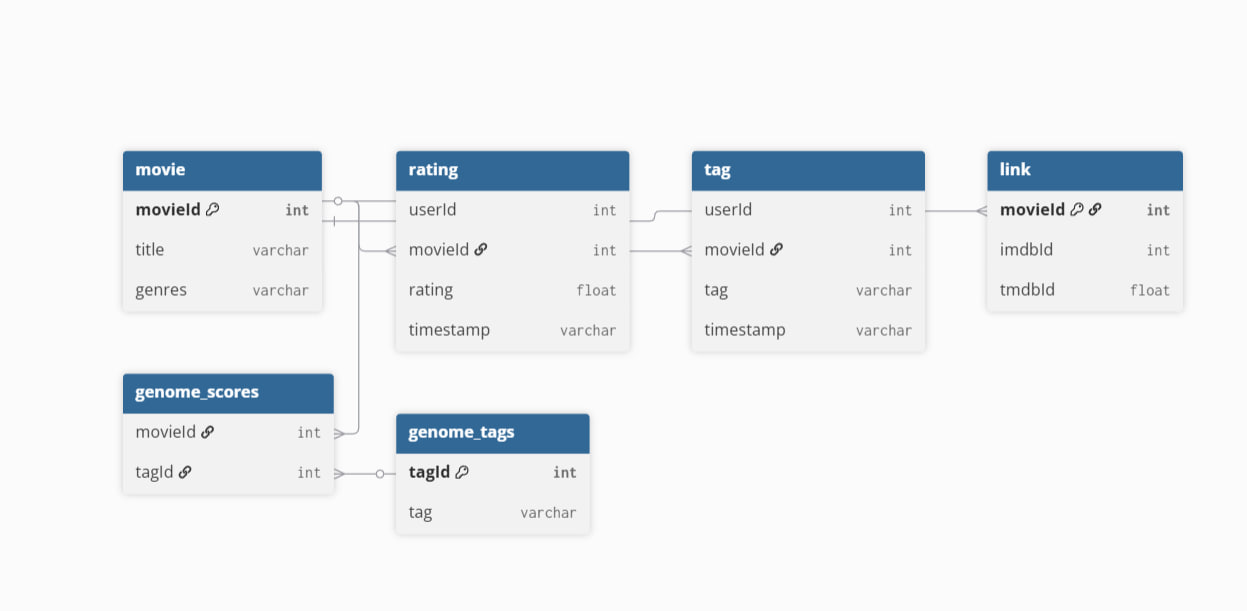

**Кратко о всех таблицах:**

1. **movie** - центральная таблица каталога фильмов с мета-информацией о фильмах.

Колонки:
- movieId - уникальный ID фильма внутри датасета (primary key)
- title - название фильма
- genres - список жанров, разделённых |

2. **rating** -  оценки, поставленные пользователями фильмам. Каждая строка — один пользователь ставит рейтинг фильму. Можно рассматривать как основной источник данных для рекомендаций.

Колонки:
- userId - уникальный пользователь
- movieId - ID фильма
- rating - оценка (0.5–5)
- timestamp - когда поставлена оценка

3. **tag** - пользовательские текстовые теги, которые пользователи вручную присвоили фильмам.
То есть субъективные, user-generated теги. Используются для поиска, персонализации и т.п.

Колонки:
- userId
- movieId
- tag - строка, например, "underrated", "space", "amazing"
- timestamp


4. **genome_tags** - нормализованный словарь тегов, созданных исследователями.Более объективные теги (без эмоций и шуток)

Колонки:
- tagId - ID тегa
- tag - текстовое название, например, "dystopia", "romantic", "detective"

5. **genome_scores** - таблица с числовой релевантность фильма каждому genome-тегу.

Колонки:

- movieId - фильм
- tagId - ссылка на genome_tags
- relevance - float от 0 до 1, насколько тег применим к фильму, например, фильм "Toy Story" → тег "animated" = 0.91

6. **link** - сопоставляет movieId с внешними ID в IMDB и TMDB.

Колонки:

- movieId

- imdbId

- tmdbId

# 2. EDA

## - Анализ таблицы df_movies

In [19]:
df_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB


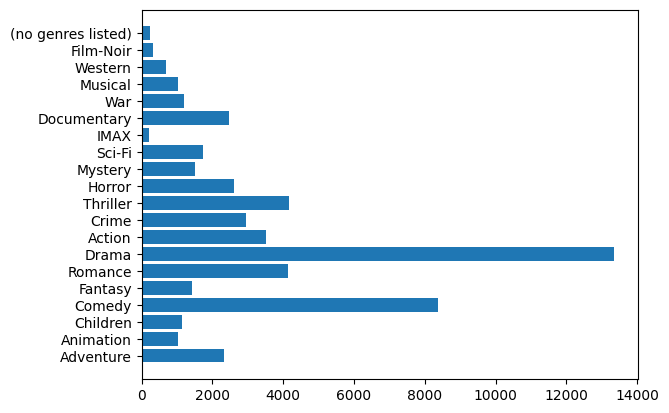

In [20]:
# Посмортим на самые популярные жанры
from collections import Counter

genres_list = df_movie['genres'].str.split('|').sum()
genre_counts = Counter(genres_list)
plt.barh(list(genre_counts.keys()), list(genre_counts.values()))
plt.show()

## - Анализ таблицы df_rating

In [21]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB


In [44]:
# у timestamp тип данных object,сделаем его временным
df_rating['timestamp'] = pd.to_datetime(df_rating['timestamp'])

Посмотрим, как пользователи чаще всего оценивают фильмы

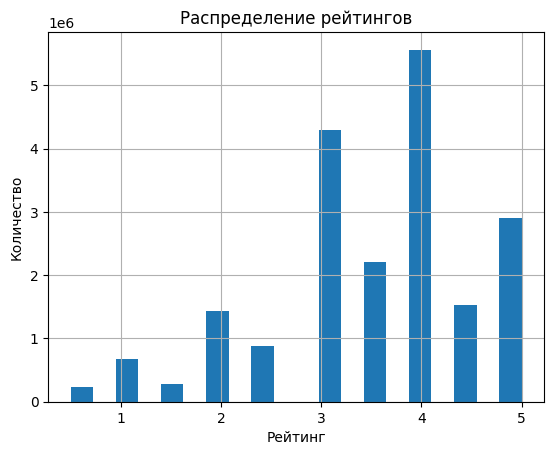

In [23]:
df_rating['rating'].hist(bins=20)
plt.title("Распределение рейтингов")
plt.xlabel("Рейтинг")
plt.ylabel("Количество")
plt.show()


Как видим большинство оценок в районе 4, что логично: люди чаще смотрят хорошие фильмы (посоветовали друзья, СМИ и тд), но не шедевры, тк их по определению меньше

Добавим признаков времени суток, а также выходных дней и признак года (некоторые пользователи смотрят только современные фильмы, другие же предпочитают классику)

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


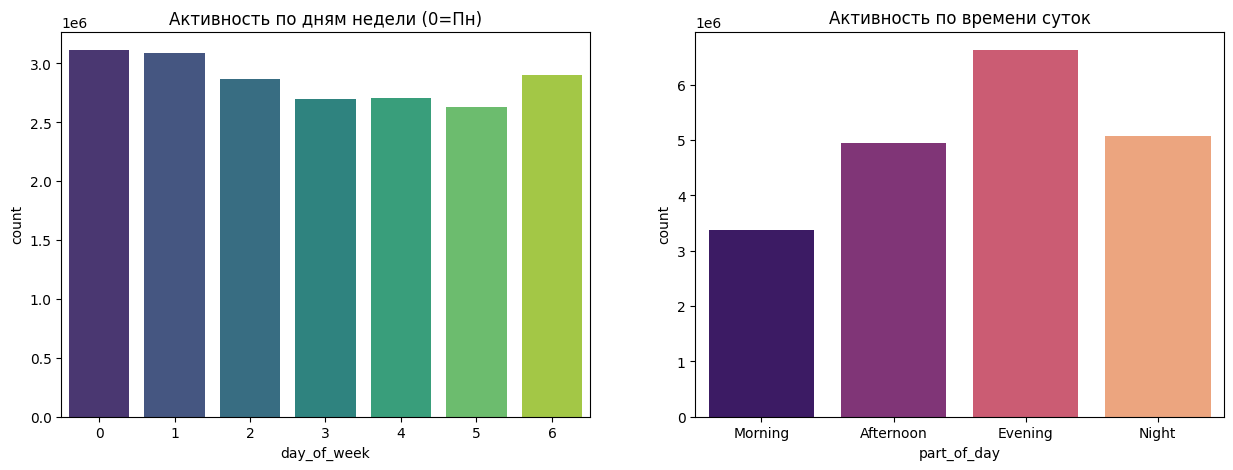

In [45]:
import seaborn as sns

# Преобразование timestamp
df_rating['date'] = pd.to_datetime(df_rating['timestamp'])

# Извлечение фичей
df_rating['year'] = df_rating['date'].dt.year
df_rating['hour'] = df_rating['date'].dt.hour
df_rating['day_of_week'] = df_rating['date'].dt.dayofweek # 0 - Пн, 6 - Вс
df_rating['is_weekend'] = df_rating['day_of_week'].isin([5, 6]).astype(int)
df_rating['part_of_day'] = pd.cut(
    df_rating['hour'], 
    bins=[0, 6, 12, 18, 24], 
    labels=['Night', 'Morning', 'Afternoon', 'Evening'],
    right=False
)


# Ответим на вопрос, когда люди чаще всего ставят оценки?
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(x='day_of_week', data=df_rating, ax=axes[0], palette='viridis')
axes[0].set_title('Активность по дням недели (0=Пн)')

sns.countplot(x='part_of_day', data=df_rating, ax=axes[1], order=['Morning', 'Afternoon', 'Evening', 'Night'], palette='magma')
axes[1].set_title('Активность по времени суток')

plt.show()

Ожидаемо было, что пользователи чаще смотрят фильмы по выходным, чем в рабочие дни недели, теория не подтвердилась. Однако по вечерам фильмы смотрят чаще, чем в другое время суток, что  логично - смотрят фильмы после рабочего дня

Проанализируем **Long-Tail**

Типичное распределение популярности контента, где узкий набор очень популярных фильмов собирает большую часть просмотров и оценок, а гигантский хвост редких и нишевых фильмов почти не получает взаимодействий. Условно большинство пользователей смотрит "Титаник" и только малая доля зрителей ищет арт-хаус.

А также имеет место закон Парето: в рекомендациях часто 1-5% контента собирает 60–90% всех просмотров

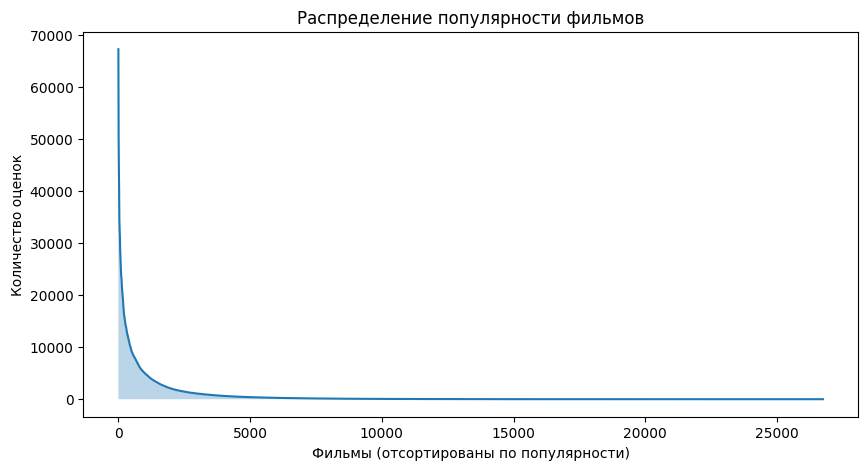

Топ 1% фильмов собирает 33.5% всех оценок.


In [46]:
# Считаем кол-во оценок на каждый фильм
movie_popularity = df_rating.groupby('movieId')['rating'].count().sort_values(ascending=False).reset_index()
movie_popularity.columns = ['movieId', 'rating_count']

# Строим график
plt.figure(figsize=(10, 5))
plt.plot(movie_popularity['rating_count'].values)
plt.title('Распределение популярности фильмов')
plt.xlabel('Фильмы (отсортированы по популярности)')
plt.ylabel('Количество оценок')
plt.fill_between(range(len(movie_popularity)), movie_popularity['rating_count'], alpha=0.3)
plt.show()

# Статистика
top_1_percent = movie_popularity['rating_count'].head(int(len(movie_popularity) * 0.01)).sum()
total_ratings = movie_popularity['rating_count'].sum()
print(f"Топ 1% фильмов собирает {top_1_percent / total_ratings:.1%} всех оценок.")

Как видим каталог распределён менее поляризованно, чем во многих других датасетах в рекомендательных системах: более широкий хвост и контент распределён ровнее, что открывает возможности для моделей, которые могут работать с большим разнообразием контента. Но всё равно есть явный минус, тк одна сотая каталога собирает треть данных, то есть модели по-прежнему будут стремиться к более популярным фильмам, игнорируя более нишевые.

Посчитаем **активность пользователей**

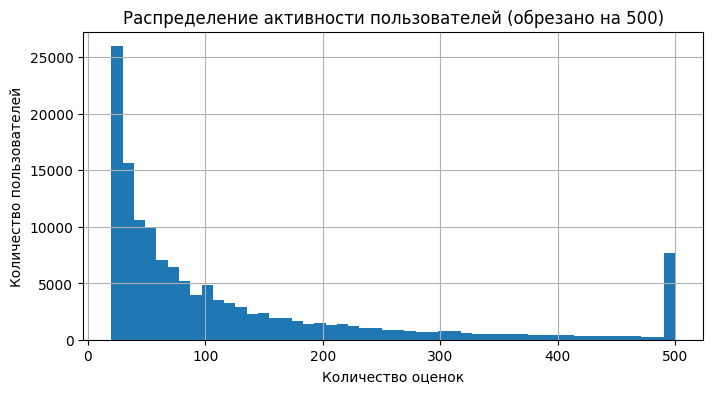

Медианное кол-во оценок на юзера: 68.0


In [47]:
# Считаем, сколько оценок поставил каждый юзер
user_activity = df_rating.groupby('userId')['rating'].count()

plt.figure(figsize=(8, 4))
user_activity.clip(upper=500).hist(bins=50) # clip(upper=500) чтобы график не сплющило из-за супер-активных
plt.title('Распределение активности пользователей (обрезано на 500)')
plt.xlabel('Количество оценок')
plt.ylabel('Количество пользователей')
plt.show()

print(f"Медианное кол-во оценок на юзера: {user_activity.median()}")

Фильтруем слишком редкие фильмы и неактивных юзеров, чтобы уменьшить шум и улучшить качество будущей модели

In [48]:
# Оставим только юзеров, которые поставили > 10 оценок и фильмы, у которых > 20 оценок
min_movie_ratings = 20
min_user_ratings = 10

movies_to_keep = movie_popularity[movie_popularity['rating_count'] > min_movie_ratings]['movieId']
users_to_keep = user_activity[user_activity > min_user_ratings].index

df_rating_filtered = df_rating[
    (df_rating['movieId'].isin(movies_to_keep)) &
    (df_rating['userId'].isin(users_to_keep))
]

print(f"Исходный размер: {len(df_rating)}")
print(f"Размер после фильтрации: {len(df_rating_filtered)}")
print(f"Потеряли данных: {1 - len(df_rating_filtered)/len(df_rating):.2%}")

Исходный размер: 20000263
Размер после фильтрации: 19930229
Потеряли данных: 0.35%


Посчитаем  **разряженность матрицы взаимодействий**, в хорошей матрице  резульат должен быть близок к 99%

In [49]:
n_users = df_rating_filtered['userId'].nunique()
n_movies = df_rating_filtered['movieId'].nunique()
n_ratings = len(df_rating_filtered)

sparsity = 1 - (n_ratings / (n_users * n_movies))
print(f"Матрица взаимодействий (Пользователи: {n_users}, Фильмы: {n_movies})")
print(f"Разреженность: {sparsity:.4f}")

Матрица взаимодействий (Пользователи: 138493, Фильмы: 12989)
Разреженность: 0.9889


Получили число близкое

Посчитаем взвешенное среднее, это позволит избежать ситуации, когда фильм с одной оценкой 5.0 будет выше шедевра с тысячей оценок и средним 4.8

In [50]:
# Вычисляем взвешенный рейтинг
C = df_rating_filtered['rating'].mean()

# Минимум голосов для попадания в топ
m = df_rating_filtered.groupby('movieId')['rating'].count().quantile(0.90) 

# Агрегируем данные
movie_stats = df_rating_filtered.groupby('movieId').agg({'rating': ['count', 'mean']})
movie_stats.columns = ['vote_count', 'vote_average']

def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

movie_stats['weighted_score'] = movie_stats.apply(weighted_rating, axis=1)

# Топ лучших фильмов по взвешенной оценке
top_movies = movie_stats.sort_values('weighted_score', ascending=False).head(10).merge(df_movie, on='movieId')
print("Топ-10 фильмов по взвешенной оценке:")
display(top_movies[['title', 'genres', 'vote_average', 'vote_count', 'weighted_score']])

Топ-10 фильмов по взвешенной оценке:


,title,genres,vote_average,vote_count,weighted_score
0,"Shawshank Redemption, The (1994)",Crime|Drama,4.446990,63366,4.395704
1,"Godfather, The (1972)",Crime|Drama,4.364732,41355,4.295237
2,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4.334372,47006,4.274854
3,Schindler's List (1993),Drama|War,4.310175,50054,4.255712
4,"Godfather: Part II, The (1974)",Crime|Drama,4.275641,27398,4.185700
5,One Flew Over the Cuckoo's Nest (1975),Drama,4.248079,29932,4.167969
6,Fight Club (1999),Action|Crime|Drama|Thriller,4.227123,40106,4.167389
7,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,4.219009,43295,4.163970
8,Casablanca (1942),Drama|Romance,4.258327,24349,4.160929
9,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.190672,54502,4.148044


## - Анализ таблиц df_link

Воспользуемся **TMDB API** для получения новых фичей

In [6]:
import requests

TMDB_API_KEY = ""

WANTED = [
    "budget", "revenue", "runtime", "vote_average", "vote_count",
    "release_date", "popularity", "adult", "homepage",
    "original_language"
]

def join_names(list_of_dicts, key="name"):
    if not list_of_dicts:
        return None
    return "|".join([d.get(key, "") for d in list_of_dicts if d.get(key)])

tmdb_ids = df_link['tmdbId'].dropna().unique()
total = len(tmdb_ids)
rows = []
session = requests.Session()

# Попытка использовать tqdm, иначе fallback
use_tqdm = True
try:
    from tqdm.auto import tqdm
    progress_iter = tqdm(tmdb_ids, desc="TMDB", unit="id")
except Exception:
    use_tqdm = False
    progress_iter = tmdb_ids

TMDB:   0%|          | 0/27008 [00:00<?, ?id/s]

In [ ]:
def _fmt_time(sec):
    if sec is None:
        return "N/A"
    m, s = divmod(int(sec), 60)
    h, m = divmod(m, 60)
    if h:
        return f"{h:d}h{m:02d}m{s:02d}s"
    if m:
        return f"{m:d}m{s:02d}s"
    return f"{s:d}s"

start_time = time.time()
for i, tmdb_id in enumerate(progress_iter):
    # если используем fallback, обновляем прогресс вручную
    if not use_tqdm:
        done = i  # пока что не считая текущий
    url = f"https://api.themoviedb.org/3/movie/{int(tmdb_id)}"
    params = {"api_key": TMDB_API_KEY, "language": "en-US"}
    try:
        r = session.get(url, params=params, timeout=10)
        if r.status_code == 200:
            j = r.json()
            row = {"tmdbId": int(tmdb_id)}
            for f in WANTED:
                row[f] = j.get(f, None)
            row["production_companies"] = join_names(j.get("production_companies", []), "name")
            rows.append(row)
        elif r.status_code == 404:
            rows.append({"tmdbId": int(tmdb_id), **{f: None for f in WANTED}, "production_companies": None})
        else:
            print(f"\nWarning: tmdb {tmdb_id} returned status {r.status_code}")
            rows.append({"tmdbId": int(tmdb_id), **{f: None for f in WANTED}, "production_companies": None})
    except Exception as e:
        print(f"\nError for {tmdb_id}: {e}")
        rows.append({"tmdbId": int(tmdb_id), **{f: None for f in WANTED}, "production_companies": None})

    # обновление строки прогресса для fallback
    if not use_tqdm:
        done = i + 1
        elapsed = time.time() - start_time
        pct = done / total * 100
        eta = (elapsed / done) * (total - done) if done else None
        print(f"\rProgress: {done}/{total} ({pct:.1f}%)  elapsed: {_fmt_time(elapsed)}  ETA: {_fmt_time(eta)}", end="", flush=True)

# если был fallback — печатаем перенос строки по завершении
if not use_tqdm:
    print()


In [ ]:
# Преобразуем в DataFrame и объеденим с df_link
df_link_api_feat = pd.DataFrame(rows)
df_link = df_link.merge(df_link_api_feat, on='tmdbId', how='left')

# и сохраним отдельно 
df_link_api_feat.to_csv("df_link_api_feat.csv", index=False)

In [52]:
import warnings

warnings.simplefilter("ignore", RuntimeWarning)
df_link

,movieId,budget,revenue,runtime,vote_average,vote_count,release_date,popularity,adult,homepage,original_language,production_companies
0,1,30000000.0,394436586.0,81.0,8.000,19296.0,1995-11-22,16.5492,False,http://toystory.disney.com/toy-story,en,Pixar
1,2,65000000.0,262821940.0,104.0,7.242,10971.0,1995-12-15,2.7834,False,http://www.sonypictures.com/movies/jumanji/,en,TriStar Pictures|Interscope Communications|Tei...
2,3,25000000.0,71500000.0,101.0,6.500,409.0,1995-12-22,2.4991,False,unknown,en,Lancaster Gate|Warner Bros. Pictures
3,4,16000000.0,81452156.0,127.0,6.260,179.0,1995-12-22,5.3930,False,unknown,en,20th Century Fox
4,5,NaN,76594107.0,106.0,6.266,777.0,1995-12-08,3.7707,False,unknown,en,Touchstone Pictures|Sandollar Productions
...,...,...,...,...,...,...,...,...,...,...,...,...
27273,131254,NaN,NaN,90.0,5.917,54.0,2007-08-30,0.4954,False,http://www.bund.film.de/,de,Medienfonds GFP|Wiedemann & Berg Film
27274,131256,NaN,3070158.0,83.0,4.323,31.0,2002-02-21,0.4935,False,unknown,de,Goldkind Filmproduktion|Warner Bros. Entertain...
27275,131258,13000000.0,64400000.0,130.0,7.000,228.0,2014-08-06,2.9837,False,http://haejuk2014.kr/,ko,Lotte Entertainment|Harimao Pictures|Cinedigm
27276,131260,NaN,NaN,103.0,6.200,15.0,2001-01-12,0.9264,False,unknown,fi,Artista Filmi


Удалим imdbId (нет доступа к api) и tmdbId (уже получили все признаки с помощью api),а также поделим все vote_average на 2, тк он измеряется в пределах от 0 до 10, а rating в таблице rating может быть только в пределе от 0 до 5 

In [53]:
import warnings

warnings.simplefilter("ignore", RuntimeWarning)
df_link['vote_average'] = df_link['vote_average'] / 2

df_link 

,movieId,budget,revenue,runtime,vote_average,vote_count,release_date,popularity,adult,homepage,original_language,production_companies
0,1,30000000.0,394436586.0,81.0,4.0000,19296.0,1995-11-22,16.5492,False,http://toystory.disney.com/toy-story,en,Pixar
1,2,65000000.0,262821940.0,104.0,3.6210,10971.0,1995-12-15,2.7834,False,http://www.sonypictures.com/movies/jumanji/,en,TriStar Pictures|Interscope Communications|Tei...
2,3,25000000.0,71500000.0,101.0,3.2500,409.0,1995-12-22,2.4991,False,unknown,en,Lancaster Gate|Warner Bros. Pictures
3,4,16000000.0,81452156.0,127.0,3.1300,179.0,1995-12-22,5.3930,False,unknown,en,20th Century Fox
4,5,NaN,76594107.0,106.0,3.1330,777.0,1995-12-08,3.7707,False,unknown,en,Touchstone Pictures|Sandollar Productions
...,...,...,...,...,...,...,...,...,...,...,...,...
27273,131254,NaN,NaN,90.0,2.9585,54.0,2007-08-30,0.4954,False,http://www.bund.film.de/,de,Medienfonds GFP|Wiedemann & Berg Film
27274,131256,NaN,3070158.0,83.0,2.1615,31.0,2002-02-21,0.4935,False,unknown,de,Goldkind Filmproduktion|Warner Bros. Entertain...
27275,131258,13000000.0,64400000.0,130.0,3.5000,228.0,2014-08-06,2.9837,False,http://haejuk2014.kr/,ko,Lotte Entertainment|Harimao Pictures|Cinedigm
27276,131260,NaN,NaN,103.0,3.1000,15.0,2001-01-12,0.9264,False,unknown,fi,Artista Filmi


## - Анализ таблиц df_genome_scores

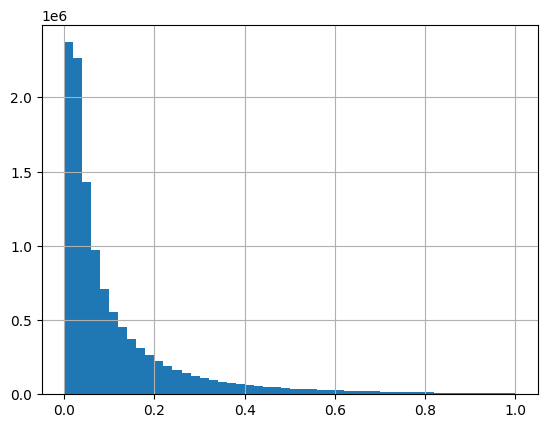

In [34]:
# Посмотрим релевантность genome tags
df_genome_scores['relevance'].hist(bins=50)
plt.show()


Большинство значений лежит в интервале от 0 до 0.2, возможно, признак малоинформативен

## - Анализ таблиц df_tag и df_genome_tags

Несмотря на одинаковые названия столбцов tag в таблицах genome_tags и tag, у них разная суть. Проверим их пересечения:

In [54]:
# Приведем к нижнему регистру
user_tags = df_tag['tag'].dropna().str.strip().str.lower().unique()
genome_tags = df_genome_tags['tag'].dropna().str.strip().str.lower().unique()

len_user = len(user_tags)
len_genome = len(genome_tags)
len_common = len(set(user_tags).intersection(set(genome_tags)))

print(f"Количество tags от пользователей: {len_user}")
print(f"Количество genome tags: {len_genome}")
print(f"Совпадений: {len_common}")

common = set(user_tags).intersection(genome_tags)
print("Примеры совпадений:", list(common)[:20], '\n')

# какие пользовательские теги не найдены в genome
user_only = list(set(user_tags) - set(genome_tags))
print("Примеры тегов которых нет в genome:", user_only[:30])


Количество tags от пользователей: 35170
Количество genome tags: 1128
Совпадений: 1128
Примеры совпадений: ['graphic novel', 'jane austen', 'wine', 'intelligent sci-fi', 'dark hero', 'fantasy world', 'best of 2005', 'catholicism', 'inspirational', 'oscar', 'funny as hell', 'oscar (best music - original song)', 'south africa', 'native americans', 'golden palm', 'hit men', 'foul language', 'man versus machine', 'irish', 'indiana jones'] 

Примеры тегов которых нет в genome: ['', 'nisha pahuja', 'dolly parten', 'stanley k', 'hitting a child', 'fracking', 'cross dressing men', 'grfgt', 'post apocalypse', 'michael ray rhodes', 'cast', 'blankness of life', 'interracial/cross-cultural romance', 'compilation of tv series', 'existential crisis', 'negative gay jokes', 'yuen chor', 'but what did they do after new years: resolve to kill all my enemies', 'great villain', "no realistic cop's freedom to act", 'antique', 'remakeof:thunderball (1965)', 'sijie dai', 'spoiled', '08.05.06', 'unsympathetic 

Теория о том, что теги от пользователей более шуточные и необъективные подверждается выше такими тегами как, например,"it thought it was funny but it wasn't?" (он думал, что это смешно, но это не так?) и "kinda overrated" (немного переоценен)

In [55]:
#Переименуем эти теги, чтоб не путаться
df_genome_tags = df_genome_tags.rename(columns={"tag": "genome_tag"})
df_tag = df_tag.rename(columns={"tag": "user_tag"})

# А также поменяем тип данных столбца timestamp из object во временной
df_tag['timestamp'] = pd.to_datetime(df_tag['timestamp'])

Создадим эмбеддинги контента: сожмем 1128 тегов генома в 32 компоненты с помощью PCA и добавим финансовые данные из df_link

In [40]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Создаем матрицу (строки - фильмы, столбцы )
genome_matrix = df_genome_scores.pivot(index='movieId', columns='tagId', values='relevance').fillna(0)

# PCA, 32 фичи вместо 1128 + Dataframe c  этими фичами
pca = PCA(n_components=32, random_state=42)
genome_pca = pca.fit_transform(genome_matrix)

pca_cols = [f'genome_pca_{i}' for i in range(32)]
df_genome_pca = pd.DataFrame(genome_pca, index=genome_matrix.index, columns=pca_cols).reset_index()

# Берем данные из df_link и соединяем с PCA
item_features_df = df_link[['movieId', 'budget', 'revenue', 'popularity', 'vote_average']].copy()

# Заполняем численные пропуски медианами
for col in ['budget', 'revenue', 'popularity', 'vote_average']:
    item_features_df[col] = item_features_df[col].fillna(item_features_df[col].median())

# Добавляем PCA признаки
item_features_df = item_features_df.merge(df_genome_pca, on='movieId', how='left').fillna(0)

# Нормализуем числовые данные
scaler = MinMaxScaler()
num_cols = ['budget', 'revenue', 'popularity', 'vote_average'] + pca_cols
item_features_df[num_cols] = scaler.fit_transform(item_features_df[num_cols])

item_features_df.head()

,movieId,budget,revenue,popularity,vote_average,genome_pca_0,genome_pca_1,genome_pca_2,genome_pca_3,genome_pca_4,...,genome_pca_22,genome_pca_23,genome_pca_24,genome_pca_25,genome_pca_26,genome_pca_27,genome_pca_28,genome_pca_29,genome_pca_30,genome_pca_31
0,1,0.079156,0.134910,0.120064,0.8000,0.412318,0.569353,0.791906,0.576319,0.611829,...,0.243484,0.440623,0.258163,0.400899,0.429762,0.277950,0.464700,0.490540,0.405218,0.375134
1,2,0.171504,0.089893,0.020194,0.7242,0.155394,0.501357,0.643093,0.538561,0.399134,...,0.557493,0.252825,0.434227,0.262747,0.373726,0.427159,0.363542,0.301288,0.522469,0.419863
2,3,0.065963,0.024455,0.018131,0.6500,0.179048,0.305918,0.572744,0.374936,0.408250,...,0.461041,0.734023,0.615043,0.416401,0.642386,0.221960,0.467278,0.539067,0.569312,0.571431
3,4,0.042216,0.027859,0.039126,0.6260,0.188125,0.217266,0.624646,0.358235,0.358483,...,0.518385,0.569425,0.367711,0.579491,0.410614,0.381547,0.445455,0.516014,0.435408,0.461745
4,5,0.021108,0.026198,0.027356,0.6266,0.143169,0.313307,0.666967,0.405199,0.449712,...,0.622723,0.637206,0.614866,0.273020,0.762420,0.211659,0.491595,0.455098,0.681453,0.560019


## - Собираем финальную таблицу

In [59]:
df_years = df_link[['movieId', 'release_date']].copy()
df_years['release_year'] = pd.to_datetime(df_years['release_date'], errors='coerce').dt.year
df_years = df_years.drop('release_date', axis=1).fillna(0)


df_item_final = item_features_df.merge(df_years, on='movieId', how='left')

# заполняем пропуски в годе 
df_item_final['release_year'] = df_item_final['release_year'].fillna(0)

# выведем информацию о финальной таблице 
print(df_item_final.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        27278 non-null  int64  
 1   budget         27278 non-null  float64
 2   revenue        27278 non-null  float64
 3   popularity     27278 non-null  float64
 4   vote_average   27278 non-null  float64
 5   genome_pca_0   27278 non-null  float64
 6   genome_pca_1   27278 non-null  float64
 7   genome_pca_2   27278 non-null  float64
 8   genome_pca_3   27278 non-null  float64
 9   genome_pca_4   27278 non-null  float64
 10  genome_pca_5   27278 non-null  float64
 11  genome_pca_6   27278 non-null  float64
 12  genome_pca_7   27278 non-null  float64
 13  genome_pca_8   27278 non-null  float64
 14  genome_pca_9   27278 non-null  float64
 15  genome_pca_10  27278 non-null  float64
 16  genome_pca_11  27278 non-null  float64
 17  genome_pca_12  27278 non-null  float64
 18  genome

# 3. Обучение модели

In [60]:
# делаем сплит по времени, чтобы не заглядывать в будущее
from sklearn.model_selection import train_test_split

df_rating_filtered = df_rating_filtered.sort_values('timestamp')

train_data, test_data = train_test_split(df_rating_filtered, test_size=0.2, shuffle=False)

print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")

Train size: 15944183
Test size: 3986046


Воспользуемся простой моделью SVD, ее главные плюсы: быстрое и простое обучение, малая нагрузка системы

In [64]:
from surprise import SVD, Dataset, Reader, accuracy

# подготовка данных для SVD
reader = Reader(rating_scale=(0.5, 5.0))
data_train = Dataset.load_from_df(train_data[['userId', 'movieId', 'rating']], reader)
trainset = data_train.build_full_trainset()

# тест в формате списка кортежей
testset = list(test_data[['userId', 'movieId', 'rating']].itertuples(index=False, name=None))

# train
svd = SVD(n_factors=100, random_state=42)
print("train SVD:")
svd.fit(trainset)

train SVD:


## 4 Тестирование

In [65]:
# Проверка
predictions_svd = svd.test(testset)
rmse_svd = accuracy.rmse(predictions_svd)
print(f"SVD RMSE: {rmse_svd:.4f}")

RMSE: 0.9268
SVD RMSE: 0.9268


In [82]:
from collections import defaultdict

def precision_at_k_surprise(predictions, k=10, threshold=3.5):
    """
    Считает Precision@K
    """
    # группируем предсказания по пользователям
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    
    for uid, user_ratings in user_est_true.items():
        # сортируем рейтинги пользователя по предсказанной оценке
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # берем топ-k
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings) 
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k]) 
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) 
                              for (est, true_r) in user_ratings[:k])

        # precision@K
        precisions[uid] = n_rel_and_rec_k / k if k > 0 else 0

    # среднее по всем пользователям
    return sum(prec for prec in precisions.values()) / len(precisions)

p_at_10_svd = precision_at_k_surprise(predictions_svd, k=10, threshold=4.0)
print(f"SVD Precision@10: {p_at_10_svd:.4f}")

SVD Precision@10: 0.5438


Это значит, что в среднем 5-6 из 10 рекомендованных фильмов реально совпадают с тем, что пользователь оценил в тесте.